# Deep Learning with Keras and Tensorflow

In [1]:
# basic library
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# tensorflow library
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)

Version:  2.3.1
Eager mode:  True
Hub version:  0.10.0


# Multi-class classification in Tensorflow-Keras

In [3]:
# dataset
dart_df = pd.read_csv('data/darts.csv')
dart_df.head()

,xCoord,yCoord,competitor
0,0.196451,-0.520341,Steve
1,0.476027,-0.306763,Susan
2,0.003175,-0.980736,Michael
3,0.294078,0.267566,Kate
4,-0.051120,0.598946,Steve


Text(0.5, 1.05, 'Dart Competitions')

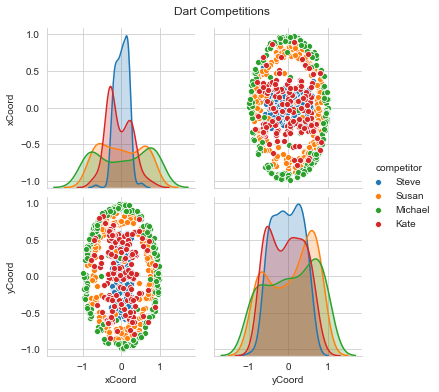

In [4]:
# EDA
sns.set_style('whitegrid')
sns.pairplot(dart_df, hue='competitor').fig.suptitle('Dart Competitions', y=1.05)

In [5]:
# check data
dart_df.describe()

,xCoord,yCoord
count,800.000000,800.000000
mean,0.005943,0.022868
std,0.475971,0.514482
min,-0.991140,-0.993547
25%,-0.295314,-0.423079
50%,0.000619,0.034483
75%,0.273953,0.452204
max,0.984816,0.994344


In [6]:
dart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   xCoord      800 non-null    float64
 1   yCoord      800 non-null    float64
 2   competitor  800 non-null    object 
dtypes: float64(2), object(1)
memory usage: 18.9+ KB


## Data Preparations

In [7]:
y = pd.get_dummies(dart_df['competitor'])
y

,Kate,Michael,Steve,Susan
0,0,0,1,0
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
795,1,0,0,0
796,0,0,1,0
797,0,1,0,0
798,0,1,0,0


In [8]:
y.columns

Index(['Kate', 'Michael', 'Steve', 'Susan'], dtype='object')

In [9]:
X = dart_df.drop(columns=['competitor'])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3,  random_state = 123, stratify=y.values)

## Modeling

In [11]:
# initialize sequential model
model = tf.keras.Sequential()

# adding hidden layer
model.add(tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# adding final/output layer
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# compiling
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# fit the model
model_hist = model.fit(X_train, y_train, epochs=200, validation_split=0.2)

l_accuracy: 0.7946
Epoch 61/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.7902 - val_loss: 0.5273 - val_accuracy: 0.8036
Epoch 62/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.7991 - val_loss: 0.5320 - val_accuracy: 0.7857
Epoch 63/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.7879 - val_loss: 0.5403 - val_accuracy: 0.7857
Epoch 64/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.7790 - val_loss: 0.5304 - val_accuracy: 0.8036
Epoch 65/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.7746 - val_loss: 0.5079 - val_accuracy: 0.8304
Epoch 66/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6018 - accuracy: 0.7857 - val_loss: 0.5253 - val_accuracy: 0.8036
Epoch 67/200
14/14 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.8013 - val_loss: 0.5145 - val_accu

In [13]:
# evaluate
accuracy = model.evaluate(X_test, y_test)
accuracy[1]

8/8 [==============================] - 0s 1ms/step - loss: 0.7222 - accuracy: 0.7667


0.7666666507720947

In [14]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 10,852
Trainable params: 10,852
Non-trainable params: 0
_________________________________________________________________


## Plotting Model

In [15]:
def plot_model(model):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    sns.set_style('darkgrid')
    ax1.plot(model.history['accuracy'])
    ax1.plot(model.history['val_accuracy'])
    ax1.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(['Train', 'Test'])

    ax2.plot(model.history['loss'])
    ax2.plot(model.history['val_loss'])
    ax2.set(title='Model Loss', xlabel='Epoch', ylabel='Loss')
    ax2.legend(['Train', 'Test'])

    plt.show()

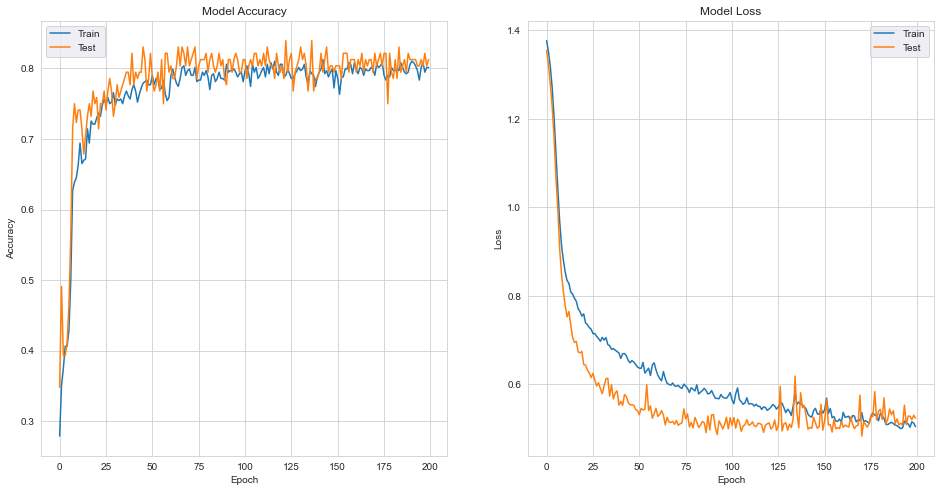

In [16]:
plot_model(model_hist)

## Keras Callbacks (EarlyStopping, ModelCheckpoint)

In [17]:
# early stopping prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# saving model
model_save = tf.keras.callbacks.ModelCheckpoint('model/4.best_model.hdf5', save_best_only=True)

# fitting model with validation
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[es, model_save])



Epoch 1/100
18/18 [==============================] - 0s 12ms/step - loss: 0.4965 - accuracy: 0.8036 - val_loss: 0.7064 - val_accuracy: 0.7583
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5159 - accuracy: 0.7893 - val_loss: 0.7442 - val_accuracy: 0.7458
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.5150 - accuracy: 0.7964 - val_loss: 0.6990 - val_accuracy: 0.7792
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4987 - accuracy: 0.8143 - val_loss: 0.7037 - val_accuracy: 0.7542
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5046 - accuracy: 0.7982 - val_loss: 0.7488 - val_accuracy: 0.7417
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5040 - accuracy: 0.8089 - val_loss: 0.7037 - val_accuracy: 0.7667
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.8018 - val_loss: 0.7095 - val_accuracy: 0.7583
Epoch 8/100


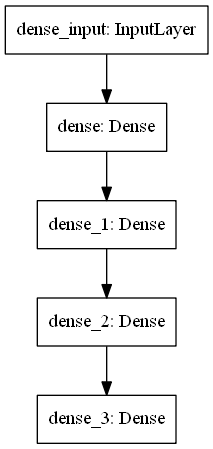

In [18]:
# Display Model
tf.keras.utils.plot_model(model, to_file='img/model_4.png')

# Improving Model 

## Changing activation function

In [20]:
# create function that return model
def get_new_model(nodes_1, nodes_2, input_shape, output_shape, activation):
    model = tf.keras.Sequential()
    # add first layer
    model.add(tf.keras.layers.Dense(nodes_1, activation=activation, input_shape = input_shape))

    # add second layer
    model.add(tf.keras.layers.Dense(nodes_2, activation='relu'))

    # add output layer
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    return(model)

In [21]:
activations = ['relu', 'sigmoid', 'tanh']

# loop over activation
activation_results = {}

for act in activations:
    model_new = get_new_model(120, 30, (2,), 4, act)
    h_callback = model.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_test, y_test))
    activation_results[act] = h_callback